In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Agents for Engineers (Evolution of AI Agents)

<a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/ai_agents_for_engineers.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

| | |
|-|-|
| Author(s) | [Kristopher Overholt](https://github.com/koverholt) [Holt Skinner](https://github.com/holtskinner)|

## Overview

This notebook demonstrates 3 different approaches to generating essays using the [Gemini Developer API](https://ai.google.dev/gemini-api/docs) or [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview). Each method illustrates a distinct paradigm for running AI Agents in differing levels of complexity.

1. Zero-Shot Approach with the Gemini API
2. Step-by-Step Approach With LangChain
3. Iterative, AI-Agent Approach with LangGraph

## Get started

### Install Gemini SDK and other required packages


In [48]:
%pip install --upgrade --quiet \
    google-genai \
    langgraph \
    langchain \
    langchain-google-genai \
    langchain-google-vertexai \
    langchain-groq \
    langchain-community \
    tavily-python \
    pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip uninstall google-generativeai google-ai-generativelanguage -y

In [ ]:
!pip install google-generativeai==0.8.4 google-ai-generativelanguage==0.6.15

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Configure Tavily

Get an API key for [Tavily](https://tavily.com/), a web search API for Generative AI models.

In [ ]:
import os

os.environ["TAVILY_API_KEY"] = "YOUR_API_KEY_HERE"

In [3]:
# If your API Keys are in Colab Secrets
import sys
import os

if "google.colab" in sys.modules:
    from google.colab import userdata

    os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

### Configure Gemini Developer API

Get API keys from [Google AI Studio](https://ai.google.dev/gemini-api/docs/api-key) and [Tavily](https://tavily.com/).

In [ ]:
import os

os.environ["GOOGLE_API_KEY"] = "YOUR_API_KEY_HERE"

In [55]:
# If your API Keys are in Colab Secrets
import sys

if "google.colab" in sys.modules:
    from google.colab import userdata

    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
    os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")


### Configure Vertex AI

**Use a Google Cloud Project:** This requires enabling the Vertex AI API in your Google Cloud project.

[Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com)

In [5]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [6]:
PROJECT_ID = "starscraper"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "true"

## Generating Essays Using a Zero-Shot Approach with the Gemini API

With just a single call to the `generate_content` method, users can create detailed, structured essays on any topic by leveraging state-of-the-art language models such as Gemini 1.5 Pro or Gemini 1.5 Flash.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/1-prompt-essay.png?raw=1" width="350px">

### Import libraries

In [7]:
from IPython.display import Markdown, display

### Create Client

In [8]:
from google import genai

client = genai.Client()

Verify which API you are using.

In [9]:
if not client.vertexai:
    print(f"Using Gemini Developer API.")
elif client._api_client.project:
    print(
        f"Using Vertex AI with project: {client._api_client.project} in location: {client._api_client.location}"
    )
elif client._api_client.api_key:
    print(
        f"Using Vertex AI in express mode with API key: {client._api_client.api_key[:5]}...{client._api_client.api_key[-5:]}"
    )

Using Vertex AI in express mode with API key: AIzaS...uWJxQ


### Load model

In [10]:
MODEL_ID = "gemini-2.0-pro-exp-02-05"

### Make an API call to generate the essay

---

However, what if we ask the model to write an essay about an event that happened more recently and the LLM doesn't inherently know about that event?

In this case, the model had no information about these recent events and was unable to write an effective essay.

## Generating Essays Using a Step-by-Step Approach With LangChain

This step demonstrates how to build an essay-writing pipeline using [LangChain](https://www.langchain.com/), the [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs), and [Tavily](https://tavily.com/) for search.

By combining these tools, we create a seamless workflow that plans an essay outline, performs web searches for relevant information, and generates a complete essay draft based on the collected data.

This solution showcases the power of chaining LLM models and external tools to tackle complex tasks with minimal human intervention, providing a robust approach to automated content generation.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/2-langchain-essay.png?raw=1" width="550px">


### Import libraries

In [56]:
from IPython.display import Markdown, display
from langchain import LLMChain
from langchain.prompts import ChatPromptTemplate
from langchain_community.tools import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_vertexai import ChatVertexAI
from langchain_groq import ChatGroq

### Initialize Gemini model & search tool

### Define prompt templates and Runnables

In [14]:
# Planning: Create an outline for the essay
outline_template = ChatPromptTemplate.from_template(
    "Create a detailed outline for an essay on {topic}"
)


# Research: Web search
def research_fn(topic):
    response = tavily_tool.invoke({"query": topic})
    return "\n".join([f"- {result['content']}" for result in response])


# Writing: Write the essay based on outline and research
writing_template = ChatPromptTemplate.from_template(
    "Based on the following outline and research, write a 3-paragraph essay on '{topic}':\n\nOutline:\n{outline}\n\nResearch:\n{research}\n\nEssay:"
)

### Define the Runnable Chain using [LangChain Expression Language (LCEL)](https://python.langchain.com/docs/how_to/#langchain-expression-language-lcel)

In [22]:
# In a cell before this one, make sure to import genai and initialize client
from google import genai

client = genai.Client()


MODEL_ID = "gemini-2.0-pro-exp-02-05"
prompt = "Write a 3-paragraph essay about the impacts of Hurricane Helene and Hurricane Milton in 2024."

In [78]:
#model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)
#model = ChatGroq(temperature=0, model_name="llama-3.3-70b-versatile")
tavily_tool = TavilySearchResults(max_results=5)

### Generate the essay

In [100]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

# Initialize both models
google_model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)
groq_model = ChatGroq(model_name="llama-3.3-70b-versatile", temperature=0)

# Create primary and backup chains
primary_outline_chain = LLMChain(llm=google_model, prompt=outline_template)
backup_outline_chain = LLMChain(llm=groq_model, prompt=outline_template)

primary_writing_chain = LLMChain(llm=google_model, prompt=writing_template)
backup_writing_chain = LLMChain(llm=groq_model, prompt=writing_template)

# Create fallback chains using the RunnableBranch approach
outline_chain = primary_outline_chain.with_fallbacks([backup_outline_chain])
writing_chain = primary_writing_chain.with_fallbacks([backup_writing_chain])

# Use the pipe operator to combine chains
chain = (
    outline_chain
    | (
        lambda result: {
            "topic": result["topic"],
            "outline": result["text"],
            "research": research_fn(result["topic"]),
        }
    )
    | writing_chain
    | (lambda result: result["text"])  # Extract the essay text from the final result
    | StrOutputParser()
)

In [77]:
essay = chain.invoke({"topic": prompt})
display(Markdown(essay))

The 2024 hurricane season was marked by two devastating storms, Hurricane Helene and Hurricane Milton, which brought widespread destruction and disruption to communities in the United States. Hurricane Helene, a large and catastrophic tropical cyclone, made landfall in northwestern Florida on September 26, 2024, and went on to affect several states, including Tennessee, Georgia, and North Carolina. The storm's high winds and flooding resulted in the loss of over 230 lives, making it the deadliest hurricane to strike the U.S. since Hurricane Maria in 2017. Hurricane Milton, which made landfall on October 9, 2024, also caused significant damage and disruption, with over 3 million customers losing power and around 150 tornado warnings being issued.

The impacts of Hurricane Helene and Hurricane Milton were far-reaching and multifaceted. In addition to the loss of life, the storms caused extensive damage to infrastructure, including buildings, roads, and bridges. The flooding and storm surges associated with the storms contaminated wells, damaged homes, and disrupted communication systems. The human impacts of the storms were also significant, with many people forced to evacuate their homes and seek shelter elsewhere. The economic losses caused by the storms were substantial, with estimates suggesting that both Hurricane Helene and Hurricane Milton will be $50 billion disasters, ranking among the most costly storms in history. The storms also had a significant impact on the environment, with experts warning that the region must improve its disaster preparedness and mitigation measures to reduce the risk of similar disasters in the future.

In the aftermath of Hurricane Helene and Hurricane Milton, emergency relief efforts and aid distribution were critical in supporting affected communities. Long-term recovery and rebuilding efforts are ongoing, with a focus on restoring damaged infrastructure and supporting businesses and industries affected by the storms. The experiences of Hurricane Helene and Hurricane Milton serve as a reminder of the importance of preparedness and mitigation measures in reducing the impacts of future hurricanes. As the world continues to grapple with the challenges of climate-related disasters, it is essential that we learn from the lessons of these storms and work towards building more resilient and sustainable communities. By doing so, we can reduce the risk of similar disasters in the future and create a safer and more secure environment for all.

## Generating Essays Using an Iterative, AI-Agent Approach with LangGraph

This section demonstrates how to build a [LangGraph](https://langchain-ai.github.io/langgraph/)-powered AI agent to generate, revise, and critique essays using large language models such as Google's [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs) or the [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/overview). The LangGraph code was adapted from the awesome DeepLearning.AI course on [AI Agents in LangGraph](https://www.deeplearning.ai/short-courses/ai-agents-in-langgraph/).

By defining a structured state flow with nodes such as "Planner," "Research Plan," "Generate," "Reflect," and "Research Critique," the system iteratively creates an essay on a given topic, incorporates feedback, and provides research-backed insights.

<img src="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/workshops/ai-agents/3-langgraph-essay.png?raw=1" width="900px">

The workflow enables automated essay generation with revision controls, making it ideal for structured writing tasks or educational use cases. Additionally, the notebook uses external search tools to gather and integrate real-time information into the essay content.

### Import libraries

In [60]:
from typing import TypedDict

# Common libraries
from IPython.display import Image, Markdown, display

# LangChain and LangGraph components
from langchain_core.messages import HumanMessage, SystemMessage

# LangChain integrations for Gemini API in Google AI Studio and Vertex AI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_vertexai import ChatVertexAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph

# Typing utilities for data validation and schema definitions
from pydantic.v1 import BaseModel

# Tavily client for performing web searches
from tavily import TavilyClient

import time
import google

### Initialize agent memory, agent state, and schema for search queries

In [61]:
# Initialize agent memory
memory = MemorySaver()


# Define the agent's state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: list[str]
    revision_number: int
    max_revisions: int


# Define a schema for search queries
class Queries(BaseModel):
    """Variants of query to search for"""

    queries: list[str]

### Initialize Gemini model and search tool

Remember to set the environment variables `GOOGLE_API_KEY` and `TAVILY_API_KEY`. And configure credentials for Vertex AI if you switch to it.

In [62]:

# Initialize Tavily client for performing web searches
tavily = TavilyClient()

### Define prompt templates for each stage

In [28]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic. Give an outline of the essay along with any
relevant notes or instructions for the sections."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 3-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Use Markdown formatting to specify a title and section headers for each paragraph.
Utilize all of the information below as needed:
---
{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can
be used when writing the following essay. Generate a list of search queries that will gather
any relevant information. Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information.
Only generate 3 queries max."""

## Utility functions

In [84]:
import re
def extract_entities(text):
    """Extract key entities from model output text"""
    # Split the text into lines and filter out empty lines
    lines = [line.strip() for line in text.split('\n') if line.strip()]

    # Look for patterns like lists, bullet points, or numbered items
    entities = []
    for line in lines:
        # Remove common list markers
        clean_line = line.lstrip('•-*#0123456789.)')
        clean_line = clean_line.strip()
        if clean_line:
            entities.append(clean_line)

    # If no structured list is found, use basic text splitting
    if not entities:
        # Split by commas, semicolons, or periods
        for part in re.split(r'[,;.]', text):
            part = part.strip()
            if part and len(part) > 3:  # Avoid very short fragments
                entities.append(part)

    return entities

def parse_claims(claims_text):
    """Extract individual claims from model-generated text"""
    # Split text by newlines and bullet points
    raw_claims = re.split(r'\n|•|\*|\d+\.', claims_text)

    # Clean up each claim
    claims = []
    for claim in raw_claims:
        claim = claim.strip()
        if claim and len(claim) > 10:  # Avoid fragments
            # Remove phrases like "Claim:" or "Fact:"
            claim = re.sub(r'^(Claim|Fact|Statement):\s*', '', claim, flags=re.IGNORECASE)
            claims.append(claim)

    return claims

def extract_score(evaluation_text):
    """Extract a numerical credibility score from evaluation text"""
    # Look for patterns like "Score: 7/10" or "Credibility: 4 out of 5"
    score_pattern = r'(\d+)(?:\s*\/\s*|\s+out\s+of\s+)(\d+)'
    match = re.search(score_pattern, evaluation_text)

    if match:
        score, scale = int(match.group(1)), int(match.group(2))
        # Normalize to 0-100 scale
        return (score / scale) * 100

    # If no explicit score, do sentiment analysis on key phrases
    positive_indicators = ['credible', 'reliable', 'authoritative', 'trustworthy', 'reputable']
    negative_indicators = ['unreliable', 'questionable', 'biased', 'unverified', 'misleading']

    score = 50  # Neutral starting point
    for word in positive_indicators:
        if word in evaluation_text.lower():
            score += 10
    for word in negative_indicators:
        if word in evaluation_text.lower():
            score -= 10

    return max(0, min(100, score))  # Clamp between 0-100

def parse_opportunities(visual_text):
    """Extract visual opportunity suggestions from text"""
    # Split by numbered or bulleted items
    opportunities = re.split(r'\n\s*\d+\.|\n\s*•|\n\s*\*', visual_text)

    # Clean up and filter
    return [opp.strip() for opp in opportunities if opp.strip() and len(opp.strip()) > 10]

def determine_visual_type(spec_text):
    """Determine the most appropriate visual type from specification text"""
    visual_types = {
        'chart': ['comparison', 'trend', 'distribution', 'percentage', 'growth', 'decline'],
        'map': ['location', 'geographic', 'regional', 'spatial', 'area', 'territory'],
        'timeline': ['chronological', 'sequence', 'history', 'progression', 'development'],
        'diagram': ['process', 'flow', 'relationship', 'structure', 'organization', 'hierarchy'],
        'infographic': ['statistics', 'facts', 'overview', 'summary', 'highlights']
    }

    # Count matches for each type
    scores = {v_type: 0 for v_type in visual_types}

    for v_type, keywords in visual_types.items():
        for keyword in keywords:
            if keyword.lower() in spec_text.lower():
                scores[v_type] += 1

    # Get the type with highest score
    max_score = max(scores.values())
    if max_score == 0:
        return "chart"  # Default

    # Return the type with highest score
    return max(scores.items(), key=lambda x: x[1])[0]

def extract_title(spec_text):
    """Extract a suitable title for the visual from specification text"""
    # Look for explicit title patterns
    title_patterns = [
        r'Title:\s*"([^"]+)"',
        r'Title:\s*(.+?)(?:\n|$)',
        r'titled\s*"([^"]+)"',
        r'titled\s*(.+?)(?:\n|$)'
    ]

    for pattern in title_patterns:
        match = re.search(pattern, spec_text)
        if match:
            return match.group(1).strip()

    # If no explicit title, extract the first sentence or phrase
    first_line = spec_text.split('\n')[0].strip()
    if len(first_line) > 50:  # Too long for a title
        first_line = first_line[:50].strip() + '...'

    return first_line

def extract_data_needs(spec_text):
    """Extract data requirements from the visual specification"""
    data_indicators = [
        r'Data needed:(.*?)(?:\n\n|\Z)',
        r'Data requirements:(.*?)(?:\n\n|\Z)',
        r'Required data:(.*?)(?:\n\n|\Z)',
        r'Data points:(.*?)(?:\n\n|\Z)'
    ]

    for pattern in data_indicators:
        match = re.search(pattern, spec_text, re.DOTALL)
        if match:
            data_text = match.group(1).strip()
            # Split into list items if it looks like a list
            if '\n' in data_text:
                return [item.strip().lstrip('-•*') for item in data_text.split('\n') if item.strip()]
            return [data_text]

    # If no explicit data section, look for data-related terms
    data_related = []
    sentences = re.split(r'[.!?]\s+', spec_text)
    for sentence in sentences:
        if any(term in sentence.lower() for term in ['data', 'statistics', 'numbers', 'figures', 'metrics']):
            data_related.append(sentence.strip())

    return data_related if data_related else ["No specific data requirements identified"]

def detect_style_preference(task_text):
    """Detect preferred writing style from task description"""
    style_indicators = {
        'academic': ['research', 'scholarly', 'academic', 'thesis', 'dissertation', 'analysis'],
        'journalistic': ['news', 'article', 'report', 'coverage', 'journalism'],
        'analytical': ['analyze', 'evaluate', 'assess', 'implications', 'critical'],
        'narrative': ['story', 'narrative', 'experience', 'personal', 'journey']
    }

    scores = {style: 0 for style in style_indicators}

    for style, keywords in style_indicators.items():
        for keyword in keywords:
            if keyword.lower() in task_text.lower():
                scores[style] += 1

    max_score = max(scores.values())
    if max_score == 0:
        return None  # No clear preference detected

    # Return style with highest score
    return max(scores.items(), key=lambda x: x[1])[0]

def detect_audience(task_text):
    """Detect target audience from task description"""
    audience_indicators = {
        'general': ['general', 'public', 'audience', 'readers', 'people'],
        'expert': ['expert', 'specialist', 'professional', 'advanced', 'technical'],
        'student': ['student', 'educational', 'classroom', 'learning', 'teaching'],
        'business': ['business', 'executive', 'management', 'corporate', 'stakeholder']
    }

    scores = {audience: 0 for audience in audience_indicators}

    for audience, keywords in audience_indicators.items():
        for keyword in keywords:
            if keyword.lower() in task_text.lower():
                scores[audience] += 1

    max_score = max(scores.values())
    if max_score == 0:
        return None  # No clear audience detected

    # Return audience with highest score
    return max(scores.items(), key=lambda x: x[1])[0]

def determine_structure(analysis_text):
    """Determine optimal essay structure based on analysis text"""
    structure_indicators = {
        'chronological': ['timeline', 'history', 'evolution', 'progression', 'over time', 'chronological'],
        'compare-contrast': ['comparison', 'contrast', 'differences', 'similarities', 'versus', 'both'],
        'problem-solution': ['problem', 'solution', 'challenge', 'resolve', 'address', 'overcome'],
        'cause-effect': ['cause', 'effect', 'result', 'impact', 'consequence', 'led to'],
        'thesis-antithesis-synthesis': ['argument', 'counterargument', 'thesis', 'antithesis', 'synthesis', 'dialectic']
    }

    scores = {structure: 0 for structure in structure_indicators}

    for structure, keywords in structure_indicators.items():
        for keyword in keywords:
            if keyword.lower() in analysis_text.lower():
                scores[structure] += 1

    max_score = max(scores.values())
    if max_score == 0:
        return 'thesis-antithesis-synthesis'  # Default to a common structure

    # Return structure with highest score
    return max(scores.items(), key=lambda x: x[1])[0]

### Define node functions for each stage

In [114]:
# Generate an outline for the essay
# Initialize both models
import json
google_model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)
groq_model = ChatGroq(model_name="qwen-qwq-32b", temperature=0)

# Create a model with fallback
model = groq_model.with_fallbacks([google_model])

def plan_node(state: AgentState):
    try:
        messages = [SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state["task"])]
        response = model.invoke(messages)
        return {"plan": response.content}
    except Exception as e:
        print(f"Error in plan_node: {e}")
        return {"plan": "Default plan: Introduction, Body, Conclusion"}


# Conducts research based on the generated plan and web search results
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state["task"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
        # Added a sleep to avoid hitting rate limits
        time.sleep(3)
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Generates a draft based on the content and plan
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}"
    )
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
        # Added a sleep to avoid hitting rate limits
    time.sleep(3)
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }


# Provides feedback or critique on the draft
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    try:
              # Added a sleep to avoid hitting rate limits
        time.sleep(3)
        response = model.invoke(messages)
    except Exception as e:
        print(f"Error encountered, using fallback mechanism: {e}")
        # The fallback will be handled automatically by the with_fallbacks mechanism
        time.sleep(3)
        response = model.invoke(messages)
    return {"critique": response.content}


# Conducts research based on the critique
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [
            SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state["critique"]),
        ]
    )
    content = state["content"] or []
    for q in queries.queries:
              # Added a sleep to avoid hitting rate limits
        time.sleep(3)
        response = tavily.search(query=q, max_results=1)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}


# Determines whether the critique and research cycle should
# continue based on the number of revisions
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"


# Advanced research capabilities
def advanced_research_node(state: AgentState):
    # Extract key entities and concepts from the task/plan
    entity_extraction = model.invoke([
        SystemMessage(content="Extract key entities, concepts, and time periods from this text:"),
        HumanMessage(content=state["task"] + "\n" + state["plan"])
    ])

    # Generate diverse query strategies (definitions, statistics, perspectives, etc.)
    query_types = ["factual overview", "statistics and data", "expert opinions",
                   "opposing viewpoints", "historical context", "recent developments"]

    content = state["content"] or []
    entities = extract_entities(entity_extraction.content)

    for entity in entities:
        for query_type in query_types:
            query = f"{entity} {query_type}"
            response = tavily.search(query=query, max_results=1)
            for r in response["results"]:
                content.append({
                    "content": r["content"],
                    "source": r["url"],
                    "query_type": query_type,
                    "entity": entity
                })

    return {"content": content}

# Fact checking and Citation Integration
def fact_check_node(state: AgentState):
    # Extract claims from the draft
    claims_extraction = model.invoke([
        SystemMessage(content="Extract all factual claims from this essay:"),
        HumanMessage(content=state["draft"])
    ])

    claims = parse_claims(claims_extraction.content)
    verified_claims = []

    for claim in claims:
        # Search for evidence
        evidence = tavily.search(query=claim, max_results=1)

        # Evaluate if the claim is supported by evidence
        verification = model.invoke([
            SystemMessage(content="Determine if this claim is supported by the evidence provided:"),
            HumanMessage(content=f"Claim: {claim}\n\nEvidence:\n{json.dumps(evidence)}")
        ])

        verified_claims.append({
            "claim": claim,
            "verification": verification.content,
            "sources": [r["url"] for r in evidence["results"]]
        })

    return {"fact_check": verified_claims}

# Multi perspective Analysis
def perspective_analysis_node(state: AgentState):
    perspectives = [
        "Economic impact perspective",
        "Environmental perspective",
        "Social impact perspective",
        "Political perspective",
        "Scientific perspective"
    ]

    analysis = {}

    for perspective in perspectives:
        analysis[perspective] = model.invoke([
            SystemMessage(content=f"Analyze the topic from a {perspective}:"),
            HumanMessage(content=state["task"])
        ]).content

    return {"perspectives": analysis}

# Style and tone Adaptation
def style_adaptation_node(state: AgentState):
    try:
        # Detect or request a style/tone preference
        styles = {
            "academic": "Formal, structured, evidence-based with sophisticated vocabulary",
            "journalistic": "Clear, factual, engaging with strong narrative flow",
            "analytical": "Logical, methodical, focused on insights and implications",
            "narrative": "Story-driven, vivid descriptions, emotional resonance"
        }

        # Either detect from the task or use a default
        style_name = detect_style_preference(state["task"]) or "academic"
        style_guide = styles[style_name]

        return {"style_preference": style_name, "style_guide": style_guide}
    except Exception as e:
        print(f"Error in style_adaptation_node: {e}")
        return {"style_preference": "academic", "style_guide": "Formal, structured, evidence-based"}

def visual_planning_node(state: AgentState):
    # Identify opportunities for visual elements
    visual_opportunities = model.invoke([
        SystemMessage(content="Identify 3-5 key points from this content that would benefit from visual representation (charts, maps, timelines, etc.):"),
        HumanMessage(content=state["draft"])
    ]).content

    # Generate specifications for each visual
    visual_specs = []
    for opportunity in parse_opportunities(visual_opportunities):
        spec = model.invoke([
            SystemMessage(content="Create a detailed specification for a visual element:"),
            HumanMessage(content=f"Topic: {opportunity}")
        ]).content

        visual_specs.append({
            "type": determine_visual_type(spec),
            "title": extract_title(spec),
            "description": spec,
            "data_needed": extract_data_needs(spec)
        })

    return {"visual_elements": visual_specs}


# Adaptive learning from user feedback
def feedback_integration_node(state: AgentState, user_feedback=None):
    if not user_feedback:
        return state

    # Analyze feedback to identify improvement areas
    feedback_analysis = model.invoke([
        SystemMessage(content="Analyze this feedback and identify specific areas for improvement:"),
        HumanMessage(content=user_feedback)
    ]).content

    # Update the writing approach based on feedback
    learning = model.invoke([
        SystemMessage(content="Based on this feedback analysis, provide specific writing adjustments:"),
        HumanMessage(content=feedback_analysis)
    ]).content

    return {"feedback_analysis": feedback_analysis, "writing_adjustments": learning}

# Ethical Consideration and Bias Detection
def bias_detection_node(state: AgentState):
    # Analyze content for potential biases
    bias_analysis = model.invoke([
        SystemMessage(content="Analyze this content for potential biases, one-sided perspectives, or ethical considerations:"),
        HumanMessage(content=state["draft"])
    ]).content

    # Generate suggestions for addressing identified issues
    if "No significant bias detected" not in bias_analysis:
        bias_mitigation = model.invoke([
            SystemMessage(content="Suggest specific revisions to address these potential biases:"),
            HumanMessage(content=bias_analysis)
        ]).content

        return {"bias_analysis": bias_analysis, "bias_mitigation": bias_mitigation}

    return {"bias_analysis": "No significant bias detected"}

# Audience Adaptation
def audience_adaptation_node(state: AgentState):
    try:
        # Detect or define target audience characteristics
        audiences = {
            "general": "Wide range of knowledge levels, diverse backgrounds",
            "expert": "Specialized knowledge, familiar with technical terms",
            "student": "Learning-focused, may need scaffolding of concepts",
            "business": "Application-oriented, interested in implications"
        }

        # Either detect from the task or use a default
        audience_type = detect_audience(state["task"]) or "general"
        audience_profile = audiences[audience_type]

        # Adapt content complexity and focus accordingly
        adaptation_guide = model.invoke([
            SystemMessage(content=f"Create guidelines for adapting this content to a {audience_type} audience ({audience_profile}):"),
            HumanMessage(content=state["draft"] if "draft" in state else state["task"])
        ]).content

        return {"audience_type": audience_type, "adaptation_guide": adaptation_guide}
    except Exception as e:
        print(f"Error in audience_adaptation_node: {e}")
        return {"audience_type": "general", "adaptation_guide": "Focus on clarity and accessibility"}


# Dynamic Structure Adaptation
def structure_optimization_node(state: AgentState):
    # Analyze content to determine optimal structure
    structure_analysis = model.invoke([
        SystemMessage(content="Analyze this content and recommend the optimal essay structure:"),
        HumanMessage(content="\n".join(state["content"]))
    ]).content

    # Generate a structural outline
    structure_types = ["chronological", "compare-contrast", "problem-solution", "cause-effect", "thesis-antithesis-synthesis"]
    recommended_structure = determine_structure(structure_analysis)

    structure_template = model.invoke([
        SystemMessage(content=f"Create a detailed outline template for a {recommended_structure} essay structure:"),
        HumanMessage(content=state["task"])
    ]).content

    return {"recommended_structure": recommended_structure, "structure_template": structure_template}

# Source Quality Evaluation
def source_evaluation_node(state: AgentState):
    content = state["content"]
    evaluated_content = []

    # Initialize the model inside the function
    google_model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)
    groq_model = ChatGroq(model_name="llama-3.3-70b-versatile", temperature=0)
    model = groq_model.with_fallbacks([google_model])

    for item in content:
        if isinstance(item, dict) and "source" in item:
            # Evaluate source credibility
            source_eval = model.invoke([
                SystemMessage(content="Evaluate the credibility of this source based on its URL and content:"),
                HumanMessage(content=f"URL: {item['source']}\nContent: {item['content']}")
            ]).content

            item["source_evaluation"] = {
                "credibility_score": extract_score(source_eval),
                "credibility_notes": source_eval
            }

        evaluated_content.append(item)

    # Filter or flag low-credibility sources
    return {"content": evaluated_content}




In [111]:
import time

def node_wrapper(func):
    """Wrapper to ensure node functions never return None"""
    def wrapper(state):
        try:
            # Introduce a delay before each node execution
            time.sleep(5)  # Adjust the delay as needed
            result = func(state)
            if result is None:
                print(f"WARNING: {func.__name__} returned None, using empty dict instead")
                return {}  # Return empty dict instead of None
            return result
        except Exception as e:
            print(f"ERROR in {func.__name__}: {e}")
            # Return empty dict to continue execution
            return {}
    return wrapper

# Apply wrapper to all node functions
planner = node_wrapper(plan_node)
structure_optimizer = node_wrapper(structure_optimization_node)
audience_adapter = node_wrapper(audience_adaptation_node)
style_adapter = node_wrapper(style_adaptation_node)
advanced_researcher = node_wrapper(advanced_research_node)
#source_evaluator = node_wrapper(source_evaluation_node)
perspective_analyzer = node_wrapper(perspective_analysis_node)
generate = node_wrapper(generation_node)
visual_planner = node_wrapper(visual_planning_node)
reflect = node_wrapper(reflection_node)
fact_checker = node_wrapper(fact_check_node)
bias_detector = node_wrapper(bias_detection_node)
research_critique = node_wrapper(research_critique_node)

### Define and compile the graph

In [112]:
# Enhanced graph with new nodes
builder = StateGraph(AgentState)

# Planning phase
builder.add_node("planner", plan_node)
builder.add_node("structure_optimizer", structure_optimization_node)
builder.add_node("audience_adapter", audience_adaptation_node)
builder.add_node("style_adapter", style_adaptation_node)

# Research phase
builder.add_node("advanced_researcher", advanced_research_node)
#builder.add_node("source_evaluator", source_evaluation_node)
builder.add_node("perspective_analyzer", perspective_analysis_node)

# Generation phase
builder.add_node("generate", generation_node)
builder.add_node("visual_planner", visual_planning_node)

# Evaluation phase
builder.add_node("reflect", reflection_node)
builder.add_node("fact_checker", fact_check_node)
builder.add_node("bias_detector", bias_detection_node)
builder.add_node("research_critique", research_critique_node)  # Added the missing node

# Define the enhanced workflow
builder.set_entry_point("planner")

# Planning workflow
builder.add_edge("planner", "structure_optimizer")
builder.add_edge("structure_optimizer", "audience_adapter")
builder.add_edge("audience_adapter", "style_adapter")
builder.add_edge("style_adapter", "advanced_researcher")

# Research workflow
builder.add_edge("advanced_researcher", "perspective_analyzer")
#builder.add_edge("source_evaluator", "perspective_analyzer")
builder.add_edge("perspective_analyzer", "generate")

# Generation and evaluation workflow
builder.add_edge("generate", "visual_planner")
builder.add_edge("visual_planner", "fact_checker")
builder.add_edge("fact_checker", "bias_detector")
builder.add_edge("bias_detector", "reflect")

# Add conditional edges for task continuation or end
builder.add_conditional_edges(
    "bias_detector",
    should_continue,
    {END: END, "reflect": "reflect"}
)

# Revision loop
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Compile the enhanced graph
enhanced_graph = builder.compile(checkpointer=memory)

### Show the compiled graph

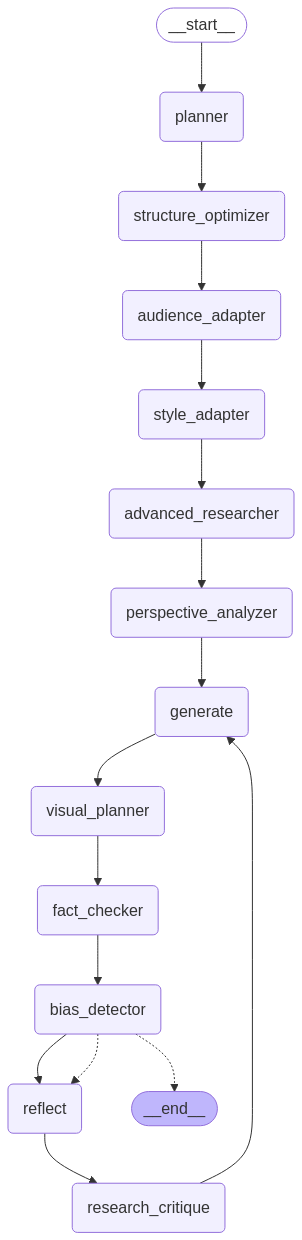

In [107]:
Image(enhanced_graph.get_graph().draw_mermaid_png())

### Run the agent - write on!

In [115]:
# Define the topic of the essay
ESSAY_TOPIC = "What were the impacts of Hurricane Helene and Hurricane Milton in 2024?"

# Define a thread configuration with a unique thread ID
thread = {"configurable": {"thread_id": "1"}}
# Create comprehensive initial state with defaults for all fields
initial_state = {
    "task": ESSAY_TOPIC,
    "max_revisions": 1,
    "revision_number": 1,
    "content": [],
    "plan": "",
    "draft": "",
    "critique": "",
    "perspectives": {},
    "audience_type": "general",
    "style_preference": "academic",
    "recommended_structure": "",
    "structure_template": "",
    "adaptation_guide": "",
    "style_guide": "",
    "visual_elements": [],
    "fact_check": [],
    "bias_analysis": ""
}

# Stream with comprehensive initial state and error handling
for s in enhanced_graph.stream(initial_state, thread):
    try:
        step = next(iter(s))
        if s[step] is None:
            print(f"WARNING: Node {step} returned None")
            display(Markdown(f"# {step} (returned None)"))
        else:
            display(Markdown(f"# {step}"))
            for key, content in s[step].items():
                if key == "revision_number":
                    display(Markdown(f"**Revision Number**: {content}"))
                elif isinstance(content, list):
                    try:
                        for c in content:
                            display(Markdown(str(c)))
                    except Exception as e:
                        print(f"Error displaying list content: {e}")
                else:
                    try:
                        display(Markdown(str(content)))
                    except Exception as e:
                        print(f"Error displaying content for {key}: {e}")
    except Exception as e:
        print(f"Error in stream processing: {e}")
    print("\n---\n")

# planner


<think>
Okay, the user is asking about the impacts of Hurricane Helene and Hurricane Milton in 2024. First, I need to check if these hurricanes actually occurred in 2024. Wait, 2024 hasn't happened yet, so maybe they're hypothetical or from a fictional scenario. The user might be referring to a projected or speculative event, perhaps for a class assignment or a creative project. 

I should start by clarifying that since 2024 is in the future, the information isn't based on real events. But the user still wants an outline, so I'll proceed under the assumption that these are fictional hurricanes for the purpose of the essay. 

The outline needs to cover both hurricanes, so I should structure it to compare and contrast their impacts. Maybe start with an introduction that sets the context of the fictional scenario. Then, separate sections for each hurricane, detailing their paths, intensity, and specific impacts like casualties, economic damage, environmental effects, and responses. 

Including a comparative analysis section would help highlight differences and similarities. Also, a section on lessons learned or future preparedness could be useful. The conclusion should summarize key points and reflect on the importance of disaster preparedness.

I should also add notes to the user, advising them to use real data if possible, or to clearly state that the scenario is fictional. Maybe suggest including sources if they're using real historical data as a basis. Also, remind them to check the latest information since the user might have a typo in the year. 

Wait, the user might have meant 2023 or another year. But since they specified 2024, I'll stick with that. Need to make sure the outline is balanced between the two hurricanes, ensuring each gets equal attention. Maybe include subsections for each impact category under each hurricane. 

Also, environmental impacts could include things like deforestation, wildlife disruption, and long-term ecological changes. Economic impacts might involve infrastructure damage, business losses, and recovery costs. Human impacts would be casualties, displacement, and health issues. 

The comparative analysis should look at factors like the regions affected, the timing of the hurricanes, and the effectiveness of the responses. Maybe one was better prepared than the other, leading to different outcomes. 

I should also mention in the notes that the user should verify the existence of these hurricanes and adjust the outline accordingly. If they're real, then the approach would be different, but since 2024 is future, it's safer to treat them as hypothetical. 

Alright, structuring the outline with clear headings and subpoints. Making sure each section flows logically from introduction to conclusion. Including notes to guide the user on how to develop each section, emphasizing the need for accurate data and proper citations.
</think>

### Essay Outline: The Impacts of Hurricane Helene and Hurricane Milton in 2024  

---

#### **I. Introduction**  
- **Hook**: Briefly introduce the 2024 Atlantic hurricane season as an unusually active or notable year.  
- **Context**: Mention that Hurricane Helene and Hurricane Milton were two of the most destructive storms of the season.  
- **Thesis Statement**: While both hurricanes caused significant damage, their impacts varied in terms of geographic reach, human toll, economic consequences, and environmental effects.  

---

#### **II. Background on the Hurricanes**  
1. **Hurricane Helene**  
   - Formation and path: Origin, peak intensity (e.g., Category 4), and trajectory (e.g., Caribbean islands, U.S. East Coast).  
   - Duration and landfall locations.  
2. **Hurricane Milton**  
   - Formation and path: Origin, peak intensity (e.g., Category 3), and trajectory (e.g., Gulf of Mexico, Central America).  
   - Duration and landfall locations.  
- **Key Difference**: Highlight contrasting paths (e.g., Helene affecting coastal urban areas, Milton impacting rural or less-developed regions).  

---

#### **III. Human and Social Impacts**  
1. **Hurricane Helene**  
   - Casualties and injuries.  
   - Displacement of populations (e.g., evacuation orders, temporary shelters).  
   - Social disruption (e.g., school closures, healthcare system strain).  
2. **Hurricane Milton**  
   - Casualties and injuries (possibly higher due to slower response in remote areas).  
   - Displacement and challenges in evacuation (e.g., limited infrastructure).  
   - Cultural impacts (e.g., damage to historical or culturally significant sites).  
- **Comparison**: Contrast urban vs. rural vulnerability and response capabilities.  

---

#### **IV. Economic Impacts**  
1. **Hurricane Helene**  
   - Damage to infrastructure (e.g., flooded cities, destroyed homes, business closures).  
   - Insurance claims and government aid (e.g., federal disaster relief).  
   - Long-term economic ripple effects (e.g., tourism decline, supply chain disruptions).  
2. **Hurricane Milton**  
   - Agricultural losses (e.g., crop destruction in farming-dependent regions).  
   - Limited insurance coverage in affected areas, leading to greater financial strain on communities.  
   - Recovery challenges due to underfunded local governments.  
- **Comparison**: Urban vs. rural economic resilience and recovery timelines.  

---

#### **V. Environmental Impacts**  
1. **Hurricane Helene**  
   - Coastal erosion, saltwater intrusion into freshwater systems.  
   - Damage to ecosystems (e.g., mangrove destruction, coral reef bleaching).  
2. **Hurricane Milton**  
   - Deforestation and landslides in mountainous regions.  
   - Contamination of water supplies from flooding.  
- **Commonality**: Both storms exacerbated climate change vulnerabilities (e.g., rising sea levels, warmer ocean temperatures).  

---

#### **VI. Response and Recovery Efforts**  
1. **Hurricane Helene**  
   - Effective early warnings and evacuation protocols.  
   - International aid and NGO involvement.  
2. **Hurricane Milton**  
   - Delays in emergency response due to logistical challenges.  
   - Reliance on local communities for initial recovery efforts.  
- **Key Takeaway**: Highlight the role of preparedness and resource allocation in mitigating damage.  

---

#### **VII. Comparative Analysis**  
- **Geographic Differences**: Urban vs. rural vulnerability.  
- **Climate and Infrastructure**: How building codes, elevation, and disaster planning influenced outcomes.  
- **Global vs. Local Impacts**: Helene’s international media attention vs. Milton’s underreported crisis.  

---

#### **VIII. Lessons Learned and Future Preparedness**  
- **Policy Recommendations**: Strengthening early warning systems, improving infrastructure in vulnerable regions.  
- **Climate Change Context**: Link the storms to broader climate trends (e.g., increased storm intensity).  
- **Call to Action**: Emphasize the need for equitable disaster response and global cooperation.  

---

#### **IX. Conclusion**  
- Recap the unique and shared impacts of both hurricanes.  
- Reiterate the importance of learning from these events to build resilience.  
- Final thought: A reflection on humanity’s preparedness for future climate-driven disasters.  

---

### **Notes for the Writer**:  
1. **Data Sources**: Since 2024 is in the future, use hypothetical scenarios based on historical analogs (e.g., reference Hurricane Ian 2022 for Helene, Hurricane Dorian 2019 for Milton).  
2. **Tone**: Maintain an academic tone but acknowledge the speculative nature of the topic.  
3. **Maps/Charts**: Suggest including fictional maps showing storm tracks and damage zones.  
4. **Ethical Consideration**: Clearly state that the hurricanes are fictional to avoid misinformation.  
5. **Sources**: Cite real studies on hurricane impacts (e.g., IPCC reports, NOAA data) to ground the analysis in reality.  

---

This outline balances structure with flexibility, allowing the writer to explore both hurricanes’ effects while emphasizing critical analysis of their differences and broader implications. Adjust details based on the essay’s required focus (e.g., environmental science, sociology, policy).


---



# structure_optimizer (returned None)


---



# audience_adapter (returned None)


---



# style_adapter (returned None)


---



KeyboardInterrupt: 

### Output the final draft of the essay

In [65]:
display(Markdown(s["generate"]["draft"]))

### The Devastating Impacts of Hurricane Helene and Hurricane Milton: A Comparative Analysis
The impacts of hurricanes on communities can be devastating, causing widespread destruction, loss of life, and long-term economic and environmental damage. Hurricane Helene and Hurricane Milton, which made landfall in 2024, are examples of significant hurricanes that had far-reaching consequences. This essay will examine the environmental, economic, and human impacts of these two hurricanes, highlighting the importance of disaster preparedness and mitigation strategies. Hurricane Helene, in particular, produced widespread and damaging landslides, while Hurricane Milton caused significant structural damage and flash flooding in several areas.

### Environmental and Economic Impacts
The environmental effects of Hurricane Helene and Hurricane Milton were severe, with storm surges, flooding, and landslides causing damage to wildlife habitats and ecosystems. Hurricane Helene made landfall in Florida as a Category 4 storm, producing record rainfall and resulting in flash flooding, road washouts, and landslides in several areas. In contrast, Hurricane Milton's outer rainbands moved across the Treasure Coast, causing an EF-0 tornado in Martin and St. Lucie counties and an EF-1 tornado in St. Lucie County, resulting in significant structural damage and vegetative damage. The economic consequences of the hurricanes were also significant, with damage to infrastructure, losses to agriculture and tourism, and disruption of supply chains and trade. The total damage from both hurricanes is likely to exceed $50 billion, making them two of the costliest hurricanes in history.

### Human Impacts and Conclusion
The human consequences of Hurricane Helene and Hurricane Milton were also severe, with loss of life, displacement, and psychological trauma reported in several areas. The response efforts of governments, NGOs, and local communities were critical in reducing the impacts of the hurricanes, with evacuation orders, emergency supplies, and shelter provided to those in need. In conclusion, the impacts of Hurricane Helene and Hurricane Milton highlight the importance of disaster preparedness and mitigation strategies in reducing the effects of hurricanes. By understanding the environmental, economic, and human impacts of these hurricanes, communities can better prepare for future disasters, reducing the risk of loss of life, property damage, and social disruption. Ultimately, the key to mitigating the effects of hurricanes lies in a combination of preparedness, planning, and proactive measures to reduce the vulnerability of communities to these powerful storms.

## Additional Resources

- [Google Cloud Generative AI repository on GitHub](https://github.com/GoogleCloudPlatform/generative-ai/)
- [Gemini API in Google AI Studio](https://ai.google.dev/gemini-api/docs)
- [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/overview)
- [LangGraph tutorials](https://langchain-ai.github.io/langgraph/tutorials/)
- [DeepLearning.AI course on AI Agents in LangGraph](https://www.deeplearning.ai/short-courses/ai-agents-in-langgraph/)